# Visualize Parameter Sweep
In this notebook we reproduce the sweep summary figures, loading precomputed data to show the best median reconstruction distances that can be achieved over a large grid of diffusion constants, sequencing depths, and satellite densities.

**Note:** Before running this notebook you must download the precomputed UMAPs and ground truth coordinates from [here](https://drive.google.com/drive/folders/16VX_xdbKzMIUz-aWH1mO8L7pQVwzNY5d?usp=sharing) and place them in the <code>data/precomputed</code> folder. The two files total ~0.5 GB.

In [1]:
import anndata
import umap
import sys
import scanpy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

sys.path.append("../functions/")
import alignment
import visuals

In [2]:
# Define the parameters for the sweep
SATELLITES_PER_CM2 = [250000, 100000, 50000, 25000]
SIGMAS_UM = [20, 25, 30, 50, 75, 100]
MEDIAN_RPBS = [10, 30, 50, 70, 90, 140, 280, 555, 1110, 2225, 4445]
rpb_to_umi = {10: 5, 30:15, 50:25, 70:30, 90:40, 140:50, 280:85, 555:130, 1110:180, 2225:225, 4445:265}\

BEADWIDTH_UM = 10 
BEADS_PER_EDGE = 315
EDGE_WIDTH = BEADS_PER_EDGE*BEADWIDTH_UM

First we load dictionaries of the pre-computed UMAPs and ground-truth coordinates. Note that to reduce the number of precomputed UMAPs, for each combination of colony density, diffusion, and sequencing depth we load the coordinates of our best reconstruction over UMAP hyperparameters. 

Since the sBC counts only give information about relative position, the embedding may be translated, shrunken, expanded, rotated, or flipped relative to the ground truth. To compare to the ground truth, we optimize for the best alignment of a simple linear transformation of the embedding. So, additionally we align each UMAP to the ground truth.

In [3]:
# Load the precomputed UMAPs and ground-truth coordinates
coords = np.load('../data/precomputed/grid-sweep-umaps.npy', allow_pickle=True)[()]
ground_truth = np.load('../data/precomputed/grid-sweep-ground-truth.npy', allow_pickle=True)[()]

In [4]:
# Create a new dictionary of UMAPs aligned to the ground truth
umaps = {}
median_dists = np.zeros((len(MEDIAN_RPBS), len(SATELLITES_PER_CM2), len(SIGMAS_UM)))

for rpb in MEDIAN_RPBS:
    for s in SIGMAS_UM:
        for c in SATELLITES_PER_CM2:
            key = '{}-{}-{}'.format(rpb, c, s)
            if key in coords.keys():
                dist_gt, aligned_coords, transf = alignment.align(coords[key], ground_truth[key])
                umaps[key] = np.concatenate([aligned_coords, dist_gt[:, np.newaxis]], axis=1)
                median_dists[MEDIAN_RPBS.index(rpb), SATELLITES_PER_CM2.index(c), SIGMAS_UM.index(s)] = np.median(dist_gt)
            else:
                median_dists[MEDIAN_RPBS.index(rpb), SATELLITES_PER_CM2.index(c), SIGMAS_UM.index(s)] = float("nan")

First, we visualize the median distance to the ground truth for each combination of colony density, diffusion, and sequencing depth, shown in Fig. S4.

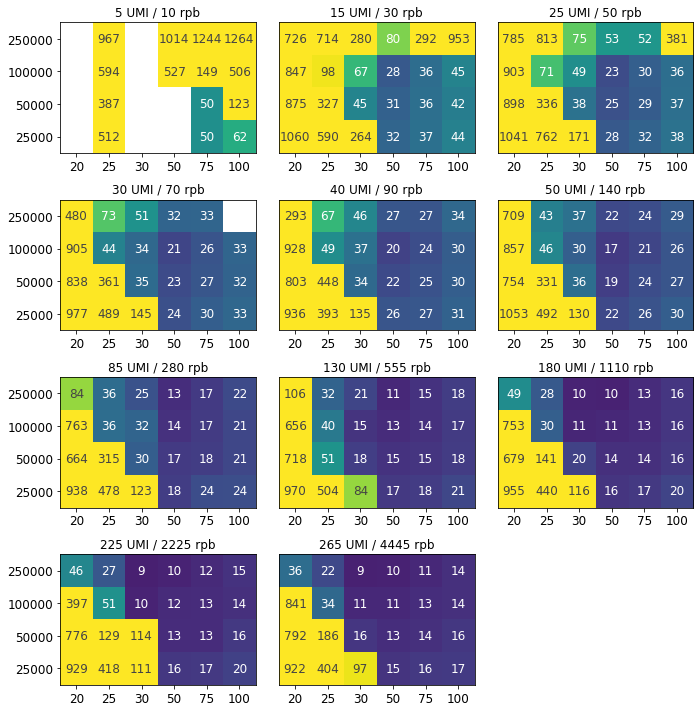

In [5]:
# Plot the best reconstruction matrices
fig = plt.figure(figsize=(10,10))
curr_plot = 1
for rpb in MEDIAN_RPBS:
    plt.subplot(4,3,curr_plot)
    curr_plot = curr_plot + 1
    plt.title('{} UMI / {} rpb'.format(rpb_to_umi[rpb], rpb), fontsize=12)
    plt.imshow(median_dists[MEDIAN_RPBS.index(rpb),:,:], vmin=0, vmax=100)
    
    plt.xticks(np.arange(len(SIGMAS_UM)), SIGMAS_UM, fontsize=12)
    if curr_plot % 3 == 2:
        plt.yticks(np.arange(len(SATELLITES_PER_CM2)), [int(c) for c in SATELLITES_PER_CM2], fontsize=12)
    else:
        plt.tick_params( axis='y',  which='both', left=False, right=False, labelleft=False)
    plt.tight_layout()
    
    # Loop over data dimensions and create text annotations.
    ax = plt.gca()
    for j in range(len(SIGMAS_UM)):
        for i in range(len(SATELLITES_PER_CM2)):
            v = np.round(median_dists[MEDIAN_RPBS.index(rpb),i,j])
            if (not np.isnan(v)) & (v > 80):
                text = ax.text(j, i, '{:.0f}'.format(v), fontsize=12, ha="center", va="center", color="#444")
            else:
                text = ax.text(j, i, '{:.0f}'.format(v), fontsize=12, ha="center", va="center", color="w")
plt.show()

Next we reproduce Fig. 4, visualizing the best reconstruction for all combinations of four diffusion levels and four sequencing depths. We also visualize the complementary cummulative distribution for each combination (Fig. S5). The complementary cummulative distribution shows the proportion of beads with a reconstruction distance beyond a given distance with dashed lines indicating 50% and 90% of beads having a reconstruction distance below that value.

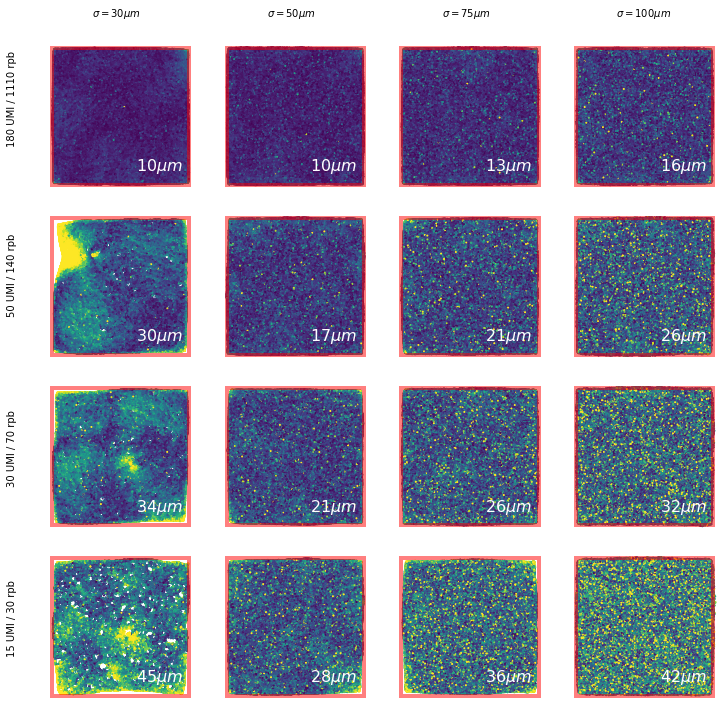

In [96]:
### Create a summary figure with only some subplots for the paper
SUMMARY_RPBS = [1110, 140, 70, 30]
SUMMARY_SIGMAS = [30, 50, 75, 100]
keys = []
fig = plt.figure(figsize=(3*len(SUMMARY_SIGMAS), 3*len(SUMMARY_RPBS)))
curr_plot = 1

ax_xmin_um = -50
ax_xmax_um = EDGE_WIDTH + 50
ax_ymin_um = -50
ax_ymax_um = EDGE_WIDTH + 50

# Shuffle the indices so outliers do not all plot on top
indices = np.arange(BEADS_PER_EDGE**2)
np.random.shuffle(indices)
    
for rpb in SUMMARY_RPBS:
    for s in SUMMARY_SIGMAS:
        c = SATELLITES_PER_CM2[np.nanargmin(median_dists[MEDIAN_RPBS.index(rpb), :, SIGMAS_UM.index(s)])]
        key = '{}-{}-{}'.format(rpb, c, s)
        keys.append(key)
        plt.subplot(len(SUMMARY_RPBS),len(SUMMARY_SIGMAS), curr_plot)
        plt.axis('off')
        curr_plot = curr_plot + 1
        if key in umaps.keys():
            plt.scatter(umaps[key][indices][:,0], umaps[key][indices][:,1], c=umaps[key][indices][:,2], s=1, rasterized=True)
            plt.clim(0, 100)
            plt.axis('equal')
            
            # Set axes limits
            ax = plt.gca()
            plt.xlim([ax_xmin_um, ax_xmax_um])
            plt.ylim([ax_ymin_um, ax_ymax_um])

            # Plot the original region
            lw = 4
            ax.add_patch(Rectangle((0 + lw/2, 0 + lw/2), EDGE_WIDTH - lw/2, EDGE_WIDTH - lw/2,
                                       edgecolor = 'red', facecolor = 'None', fill = False, lw=lw, alpha=0.5))

            # Add axes labels
            plt.text(0.6*ax_xmax_um, 0.1*ax_ymax_um, s='${:.0f} \mu m$'.format(median_dists[MEDIAN_RPBS.index(rpb), SATELLITES_PER_CM2.index(c), SIGMAS_UM.index(s)]), c='w', fontsize=16, fontweight='bold')
            
            if rpb == SUMMARY_RPBS[0]:
                plt.text(x=ax_xmin_um + 0.3*(ax_xmax_um - ax_xmin_um), y=ax_ymax_um + 0.2*(ax_ymax_um - ax_ymin_um), s="$\sigma = {} \mu m$".format(s))

            if s == SUMMARY_SIGMAS[0]:
                plt.text(x=ax_xmin_um - 0.3*(ax_xmax_um - ax_xmin_um), y=ax_ymin_um + 0.3*(ax_ymax_um - ax_ymin_um), s="{} UMI / {} rpb".format(rpb_to_umi[rpb], rpb), rotation=90)

plt.show()

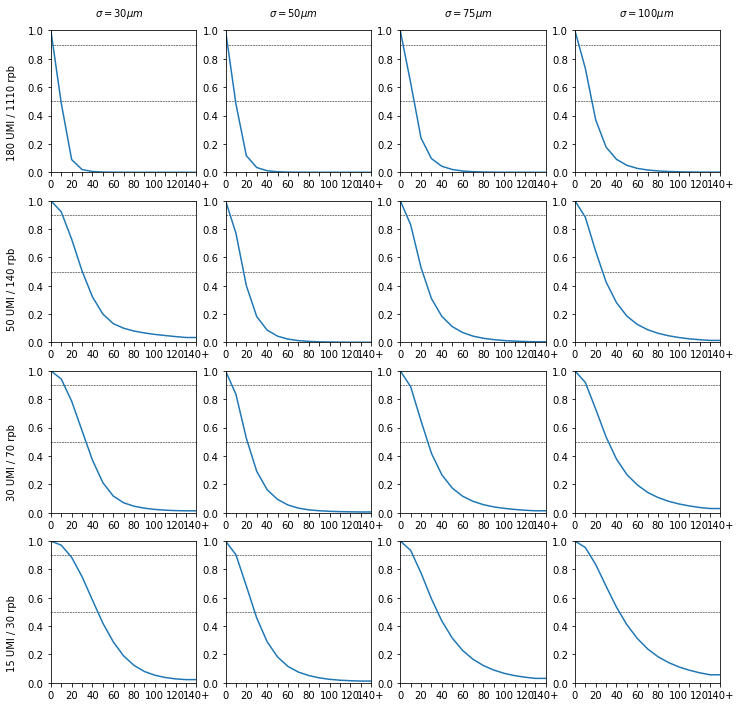

In [94]:
# Create the complementary cummulative distribution plot for the sweep
max_dist_um = 140
step_um = 10
        
bins, vals = visuals.compute_bins(umaps, keys, max_dist_um=max_dist_um, step_um=step_um)

fig = plt.figure(figsize=(3*len(SUMMARY_SIGMAS), 3*len(SUMMARY_RPBS)))
curr_plot = 1

xticks = np.arange(0,max_dist_um+1,step_um)
xlabels = ['{}+'.format(int(t)) if t == max(xticks) else '{}'.format(int(t)) if t % 20 == 0 else '' for t in xticks]

for rpb in SUMMARY_RPBS:
    for s in SUMMARY_SIGMAS:
        c = SATELLITES_PER_CM2[np.nanargmin(median_dists[MEDIAN_RPBS.index(rpb), :, SIGMAS_UM.index(s)])]
        key = '{}-{}-{}'.format(rpb, c, s)
        
        plt.subplot(len(SUMMARY_RPBS),len(SUMMARY_SIGMAS), curr_plot)
        curr_plot = curr_plot + 1
        
        plt.plot(bins[key], 1 - vals[key])

        plt.xlim([0, max_dist_um])
        plt.ylim([0,1])
        plt.xticks(ticks=xticks, labels=xlabels)
        
        plt.axhline(0.9, c='k', linestyle='dashed', linewidth=0.5, zorder=0)
        plt.axhline(0.5, c='k', linestyle='dashed', linewidth=0.5, zorder=0)
    
        # Add axes labels
        if rpb == SUMMARY_RPBS[0]:
            plt.text(x=0.3*max_dist_um, y=1.1, s="$\sigma = {} \mu m$".format(s))

        if s == SUMMARY_SIGMAS[0]:
            plt.text(x=-0.3*max_dist_um, y=0.1, s="{} UMI / {} rpb".format(rpb_to_umi[rpb], rpb), rotation=90)
        
        
plt.show()

Finally, we calculate and visualize the minimum median UMI per bead needed to achieve several reconstruction thresholds for all combinations of four diffusion levels and four satellite densities (Fig. S3).

In [84]:
# Calculate the minimum RPB for each threshold
min_umis = {}
THRESHOLDS_UM = [10, 20, 30, 40]

for thresh in THRESHOLDS_UM:
    min_umis[thresh] = np.zeros((len(SATELLITES_PER_CM2), len(SUMMARY_SIGMAS)))
    
    for c in SATELLITES_PER_CM2:
        i = SATELLITES_PER_CM2.index(c)
        for s in SUMMARY_SIGMAS:
            j = SIGMAS_UM.index(s)
            jj = SUMMARY_SIGMAS.index(s)
            loc = np.where(median_dists[:,i,j] < thresh)[0]
            min_umis[thresh][i,jj] = float('nan') if len(loc) < 1 else rpb_to_umi[MEDIAN_RPBS[loc[0]]]

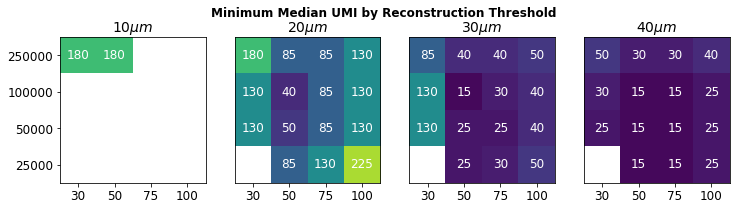

In [91]:
# Plot minimum UMI for reconstruction threshold matrices
fig = plt.figure(figsize=(12,3))
plt.suptitle('Minimum Median UMI by Reconstruction Threshold', fontweight='bold', fontsize=12)
curr_plot = 1

for thresh in THRESHOLDS_UM:
    plt.subplot(1,4,curr_plot)
    curr_plot = curr_plot + 1
    plt.imshow(min_umis[thresh], vmin=10, vmax=256)
    plt.title('${} \mu m$'.format(thresh), fontsize=14)
    
    # Annoate the cells
    for j in range(len(SUMMARY_SIGMAS)):
        for i in range(len(SATELLITES_PER_CM2)):
            v = min_umis[thresh][i,j]
            if not np.isnan(v):
                plt.text(j, i, "{:.0f}".format(v), fontsize=12, ha="center", va="center", color="w") 

    # Label the axes
    plt.xticks(np.arange(len(SUMMARY_SIGMAS)), SUMMARY_SIGMAS, fontsize=12)
    if thresh == THRESHOLDS_UM[0]:
        plt.yticks(np.arange(len(SATELLITES_PER_CM2)), SATELLITES_PER_CM2, fontsize=12)
    else:
        plt.tick_params( axis='y',  which='both', left=False, right=False, labelleft=False)
            
plt.show()